# Neural Network

Goals of this notebook: 
- Experiment with different neural network architectures. Try 
    - leaky relu activation, 
    - different drop outs, 
    - lower # of epochs, 
    - undersampling, 
    - a larger validation split.
- try hyperparameter optimization

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torchvision import datasets, transforms

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import regularizers

from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt
import bokeh
import bokeh.plotting
from bokeh.layouts import column, row
from bokeh.models import HoverTool,WheelZoomTool, PanTool, ResetTool
bokeh.io.output_notebook()

Loading BokehJS ...

#### Load the data, normalize, and split into a training and validation set

In [2]:
def data_processed():
    '''
    Used to read & normalize processed test and train data
    '''
    data_train = pd.read_csv("data/2022-02-07_LOANS_TRAIN.csv")
    data_test = pd.read_csv("data/2022-02-07_LOANS_TEST.csv")
    y_train = data_train['loan_status']
    data_train.drop('loan_status', 1, inplace=True)
    data_train.drop('id', 1, inplace=True)
    data_test.drop('id', 1, inplace=True)
    
    scaler = StandardScaler()
    scaler.fit(data_train)
    normal_data_train = scaler.transform(data_train)
    normal_data_test = scaler.transform(data_test)
    
    return normal_data_train, normal_data_test, y_train

def to_submission(y_test_predicted_probability):
    y_test = pd.DataFrame(y_test_predicted_probability, columns=['loan_status'])
    y_test.to_csv('data/submission.csv', index_label='id')
    return

In [16]:
X_train, X_test, y_train = data_processed()

print(f"""
X_train shape: {X_train.shape}
y_train shape: {y_train.shape}
""")

/var/folders/h7/dxctt03x2vjdfbhcmgymr3400000gn/T/ipykernel_17571/1340814763.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_train.drop('loan_status', 1, inplace=True)
/var/folders/h7/dxctt03x2vjdfbhcmgymr3400000gn/T/ipykernel_17571/1340814763.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_train.drop('id', 1, inplace=True)
/var/folders/h7/dxctt03x2vjdfbhcmgymr3400000gn/T/ipykernel_17571/1340814763.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_test.drop('id', 1, inplace=True)



X_train shape: (197250, 92)
y_train shape: (197250,)



### Try undersampling the data

In [17]:
fraction = 1
rus = RandomUnderSampler(random_state=0, sampling_strategy=fraction)
X_train, y_train = rus.fit_resample(X_train, y_train)

print(f"""
X_train shape: {X_train.shape}
y_train shape: {y_train.shape}
""")


X_train shape: (60448, 92)
y_train shape: (60448,)



We only use ~30% of the dataset.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=42, shuffle=True)

print(f"""
X_train shape: {X_train.shape}
y_train shape: {y_train.shape}
X_test shape: {X_test.shape}
y_test shape: {y_test.shape}
""")


X_train shape: (40500, 92)
y_train shape: (40500,)
X_test shape: (19948, 92)
y_test shape: (19948,)



In [19]:
# change to one hot encoding
#y_train, y_val = to_categorical(y_train), to_categorical(y_val)

Write function to plot training history

In [12]:
def plot_results(history):
    tools = [PanTool(), WheelZoomTool(), ResetTool(), HoverTool()]
    p = bokeh.plotting.figure(title='Training and validation loss', tools=tools)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    p.line(epochs, loss, color='blue', legend_label='Training loss')
    p.line(epochs, val_loss, color='red', legend_label='Validation loss')
    p.yaxis.axis_label = "Loss"
    p.xaxis.axis_label = 'Epochs'
    p.legend.click_policy="hide"
    p.legend.visible=False

    q = bokeh.plotting.figure(title='Training and validation accuracy', tools=tools)
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    q.line(epochs, acc, color='blue', legend_label='training')
    q.line(epochs, val_acc, color='red', legend_label='validation')
    q.yaxis.axis_label = "Accuracy"
    q.xaxis.axis_label = 'Epochs'
    q.legend.click_policy="hide"
    q.legend.location="bottom_right"
    bokeh.io.show(row(p, q))

## Try something new

In [26]:
from keras.models import Sequential
from keras.layers import Dense

def build_model():
    model = Sequential()
    model.add(Dense(20, input_dim=92, activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

from keras.wrappers.scikit_learn import KerasClassifier
keras_model = build_model()
keras_model.fit(X_train, y_train, epochs=10, batch_size=100, verbose=1)

Epoch 1/5
405/405 [==============================] - 1s 1ms/step - loss: 0.6711 - accuracy: 0.5951
Epoch 2/5
405/405 [==============================] - 0s 1ms/step - loss: 0.6410 - accuracy: 0.6356
Epoch 3/5
405/405 [==============================] - 0s 1ms/step - loss: 0.6357 - accuracy: 0.6406
Epoch 4/5
405/405 [==============================] - 0s 1ms/step - loss: 0.6325 - accuracy: 0.6430
Epoch 5/5
405/405 [==============================] - 0s 1ms/step - loss: 0.6307 - accuracy: 0.6444


In [21]:
from sklearn.metrics import roc_curve
y_pred_keras = keras_model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

In [22]:
from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

In [23]:
from sklearn.ensemble import RandomForestClassifier
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=10)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

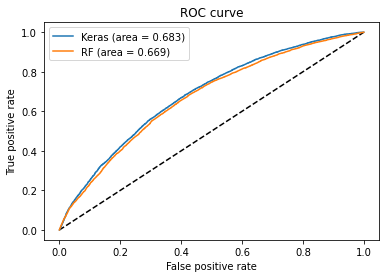

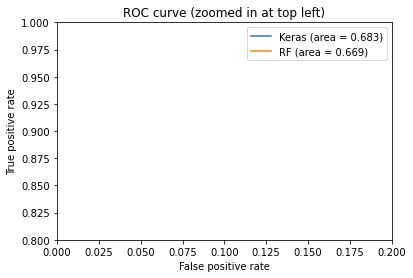

In [24]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()